In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import zipfile
import io
import os
import sys
import json
import geopandas as gpd
from gridstatus import EIA
from us import states
import census
from dotenv import load_dotenv

load_dotenv("../../.env")

True

In [2]:
eia = EIA()

In [3]:
eia.list_routes("electricity")

{'id': 'electricity',
 'name': 'Electricity',
 'description': 'EIA electricity survey data',
 'routes': [{'id': 'retail-sales',
   'name': 'Electricity Sales to Ultimate Customers',
   'description': 'Electricity sales to ultimate customer by state and sector (number of customers, average price, revenue, and megawatthours of sales).  \n    Sources: Forms EIA-826, EIA-861, EIA-861M'},
  {'id': 'electric-power-operational-data',
   'name': 'Electric Power Operations (Annual and Monthly)',
   'description': 'Monthly and annual electric power operations by state, sector, and energy source.\n    Source: Form EIA-923'},
  {'id': 'rto',
   'name': 'Electric Power Operations (Daily and Hourly)',
   'description': 'Hourly and daily electric power operations by balancing authority.  \n    Source: Form EIA-930'},
  {'id': 'state-electricity-profiles',
   'name': 'State Specific Data',
   'description': 'State Specific Data'},
  {'id': 'operating-generator-capacity',
   'name': 'Inventory of Opera

In [4]:
routes = eia.list_routes("electricity/operating-generator-capacity")

In [5]:
routes['data']

{'nameplate-capacity-mw': {'alias': 'Nameplate Capacity', 'units': 'MW'},
 'net-summer-capacity-mw': {'alias': 'Net Summer Capacity', 'units': 'MW'},
 'net-winter-capacity-mw': {'alias': 'Net Winter Capacity', 'units': 'MW'},
 'operating-year-month': {'alias': 'Operating Date (Year and Month)'},
 'planned-retirement-year-month': {'alias': 'Planned Retirement Date (Year and Month)'},
 'planned-derate-year-month': {'alias': 'Planned Derate Date (Year and Month)'},
 'planned-derate-summer-cap-mw': {'alias': 'Magnitude of Planned Derate (Summer Capacity)',
  'units': 'MW'},
 'planned-uprate-year-month': {'alias': 'Planned Uprate Date (Year and Month)'},
 'planned-uprate-summer-cap-mw': {'alias': 'Magnitude of Planned Uprate (Summer Capacity)',
  'units': 'MW'},
 'county': {'alias': 'County'},
 'longitude': {'alias': 'Longitude'},
 'latitude': {'alias': 'Latitude'}}

In [6]:
facet_list = eia.list_facets("electricity/operating-generator-capacity")

In [11]:
facet_list.keys()

dict_keys(['stateid', 'sector', 'entityid', 'plantid', 'generatorid', 'unit', 'technology', 'energy_source_code', 'prime_mover_code', 'balancing_authority_code', 'status'])

In [9]:
BASE_URL = "https://api.eia.gov/v2/"

In [10]:
dataset = "electricity/operating-generator-capacity"
route = dataset + "/data"

In [33]:
DATASET_CONFIG = {
    "electricity/operating-generator-capacity": {
        "index": [
            "period",
            "balancing_authority_code",
            "stateid",
            "plantid",
            # "balancing_authority_code",
        ],
        # "handler": _handle_rto_interchange,
    },
}


In [148]:
start_str = "2024-01"
end_str = "2024-04"
frequency= 'monthly'
facets = {'balancing_authority_code':['SWPP'],
          'stateid':['KS','MO']}

params = {
            "start": start_str,
            "end": end_str,
            "frequency": frequency,
            "facets": facets,
            "offset": 0,
            "length": 5000,
            "data":["county", 
                    "longitude",
                    "latitude",
                    "nameplate-capacity-mw",
                    "operating-year-month",
                    "planned-retirement-year-month"],
            # pagination breaks if not sorted because
            # api doesn't return in stable order across requests
            "sort": [
                {"column": col, "direction": "asc"}
                for col in DATASET_CONFIG[dataset]["index"]
            ],
        }
headers = {
            "X-Api-Key": eia.api_key,
            "X-Params": json.dumps(params),
        }

In [149]:
r = requests.get(BASE_URL+route, headers=headers)
r

<Response [200]>

In [150]:
response = r.json()['response']
data = response['data']

In [151]:
df = pd.DataFrame(data)

In [153]:
locations = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='EPSG:4326')

In [163]:
gdf = gpd.GeoDataFrame(df, geometry=locations)

In [300]:
ks_url = states.KS.shapefile_urls()['county']
mo_url = states.MO.shapefile_urls()['county']


In [301]:
ks = gpd.read_file(ks_url)

In [302]:
mo = gpd.read_file(mo_url)

In [164]:
gdf = gdf.set_index(['stateid','county','plantid','entityName'])

In [191]:
gdf.replace([ 'Natural Gas Fired Combustion Turbine',
              'Natural Gas Steam Turbine',
              'Natural Gas Fired Combined Cycle',
              'Natural Gas Internal Combustion Engine', 
              'Landfill Gas'], 
            "Natural Gas",
            inplace=True)

In [226]:
gdf.replace({'Conventional Hydroelectric':'Hydro',
             'Onshore Wind Turbine':'Wind Turbine',
             'Conventional Steam Coal':'Coal',
             'Petroleum Liquids':'Petroleum',
             'Solar Photovoltaic':'Solar PV',
             },
            inplace=True)

In [214]:
gdf['nameplate-capacity-mw'] = gdf['nameplate-capacity-mw'].astype('float')

In [227]:
gdf_pivoted = gdf.pivot_table(index='stateName',
                columns='technology',
                values='nameplate-capacity-mw',
                aggfunc='sum')

In [258]:
color = {'Coal':'saddlebrown',
         'Batteries':'tab:pink',
         'Solar PV':'gold',
         'Petroleum':'k',
         'Hydro':'cyan',
         'Wind Turbine':'lime',
         'Nuclear':'tab:green',
         'Natural Gas':'tab:orange',
         'All Other':'darkred'}

In [259]:
color_list = [color[tech] for tech in gdf['technology']]

In [308]:
wyandotte = ks[ks['NAME10']=='Wyandotte']

In [319]:
wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_crs(epsg=4269).to_frame()

,0
20,"POLYGON ((-93.84042 39.08375, -93.84920 39.013..."


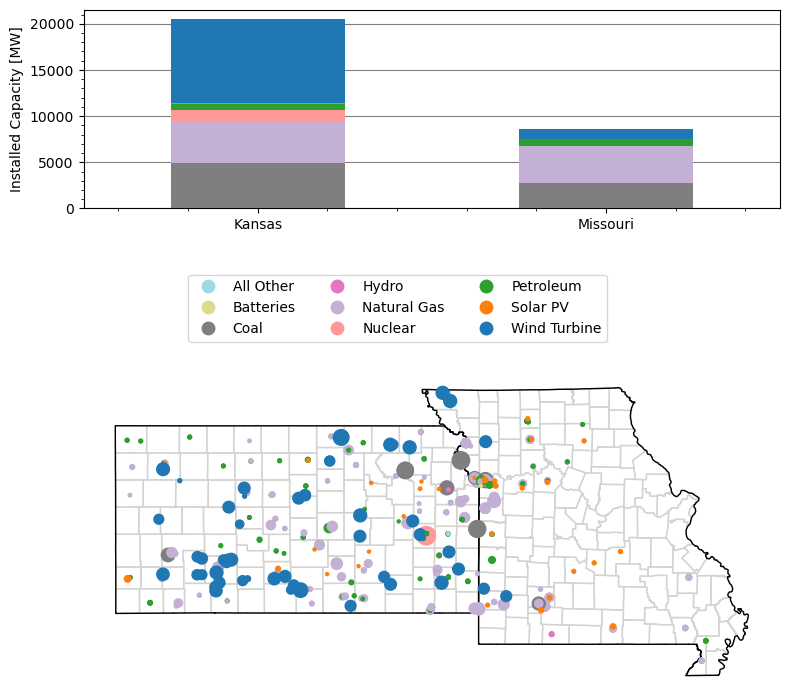

In [306]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                    #    width_ratios=[1,1],
                       height_ratios=[1,2.5]
                       )
color_map = 'tab20_r'
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

# get a buffer zone around Wyandotte County, KS
# wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_crs(epsg=4269)


gdf_pivoted.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)
# ax[0].legend(title='')
ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)
# ax[0].grid(which='minor',linestyle='--', alpha=0.5)

plt.tight_layout()

## Within 50 miles of Wyandotte County, Kansas

In [330]:
buffered_plants = gpd.sjoin(gdf.to_crs(epsg=6922),wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_frame(), how='inner').to_crs(epsg=4269)

In [331]:
buffered_plants

period stateName  \
stateid county  plantid entityName                                      
KS      Douglas 1250    Evergy Kansas Central, Inc  2024-01    Kansas   
                        Evergy Kansas Central, Inc  2024-01    Kansas   
                1262    City of Baldwin City- (KS)  2024-01    Kansas   
                        City of Baldwin City- (KS)  2024-01    Kansas   
                        City of Baldwin City- (KS)  2024-01    Kansas   
...                                                     ...       ...   
MO      DeKalb  60672   Osborn Wind Energy LLC      2024-01  Missouri   
        Jackson 61092   MC Power Companies Inc      2024-01  Missouri   
                61588   MC Power Companies Inc      2024-01  Missouri   
                        MC Power Companies Inc      2024-01  Missouri   
                65296   Evergy, Inc.                2024-01  Missouri   

                                                              sector  \
stateid county  plantid entityName                                     
KS      Douglas 1250    Evergy Kansas Central, Inc  electric-utility   
                        Evergy Kansas Central, Inc  electric-utility   
                1262    City of Baldwin City- (KS)  electric-utility   
                        City of Baldwin City- (KS)  electric-utility   
                        City of Baldwin City- (KS)  electric-utility   
...                                                              ...   
MO      DeKalb  60672   Osborn Wind Energy LLC           ipp-non-chp   
        Jackson 61092   MC Power Companies Inc           ipp-non-chp   
                61588   MC Power Companies Inc           ipp-non-chp   
                        MC Power Companies Inc           ipp-non-chp   
                65296   Evergy, Inc.                     ipp-non-chp   

                                                          sectorName entityid  \
stateid county  plantid entityName                                              
KS      Douglas 1250    Evergy Kansas Central, Inc  Electric Utility    22500   
                        Evergy Kansas Central, Inc  Electric Utility    22500   
                1262    City of Baldwin City- (KS)  Electric Utility     1148   
                        City of Baldwin City- (KS)  Electric Utility     1148   
                        City of Baldwin City- (KS)  Electric Utility     1148   
...                                                              ...      ...   
MO      DeKalb  60672   Osborn Wind Energy LLC           IPP Non-CHP    60397   
        Jackson 61092   MC Power Companies Inc           IPP Non-CHP    58822   
                61588   MC Power Companies Inc           IPP Non-CHP    58822   
                        MC Power Companies Inc           IPP Non-CHP    58822   
                65296   Evergy, Inc.                     IPP Non-CHP    64428   

                                                                     plantName  \
stateid county  plantid entityName                                               
KS      Douglas 1250    Evergy Kansas Central, Inc      Lawrence Energy Center   
                        Evergy Kansas Central, Inc      Lawrence Energy Center   
                1262    City of Baldwin City- (KS)     Baldwin City Plant No 1   
                        City of Baldwin City- (KS)     Baldwin City Plant No 1   
                        City of Baldwin City- (KS)     Baldwin City Plant No 1   
...                                                                        ...   
MO      DeKalb  60672   Osborn Wind Energy LLC              Osborn Wind Energy   
        Jackson 61092   MC Power Companies Inc         Independence Solar Farm   
                61588   MC Power Companies Inc      Independence II Solar Farm   
                        MC Power Companies Inc      Independence II Solar Farm   
                65296   Evergy, Inc.                          Hawthorn Solar I   

                                             

In [332]:
buffered_plants_pivot = buffered_plants.pivot_table(index='stateName',
                columns='technology',
                values='nameplate-capacity-mw',
                aggfunc='sum')

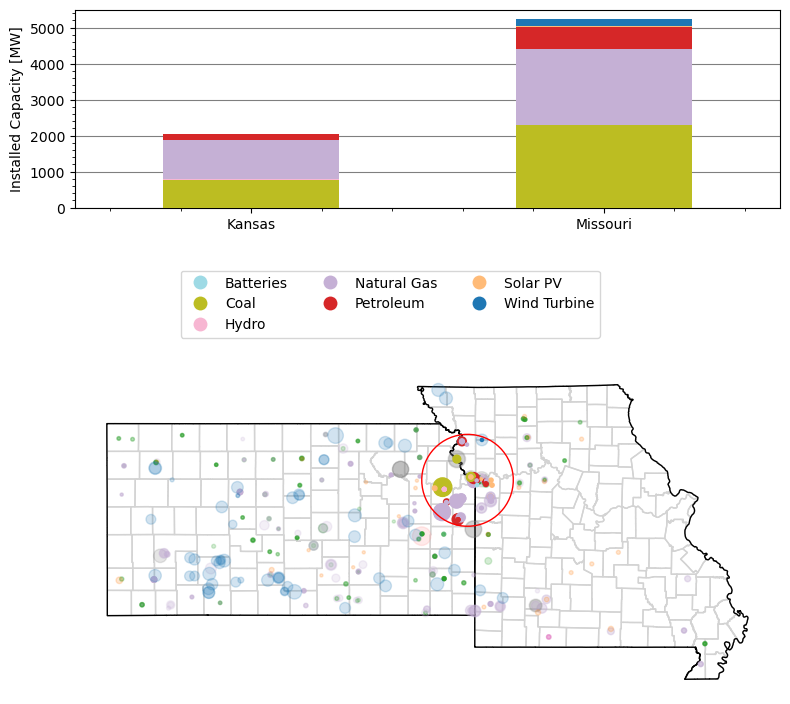

In [333]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                    #    width_ratios=[1,1],
                       height_ratios=[1,2.5]
                       )
color_map = 'tab20_r'
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           alpha=0.2,
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

buffered_plants.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )
# get a buffer zone around Wyandotte County, KS
wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_crs(epsg=4269).plot(ax=ax[1], facecolor='None', edgecolor='r')


buffered_plants_pivot.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)
# ax[0].legend(title='')
ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)
# ax[0].grid(which='minor',linestyle='--', alpha=0.5)

plt.tight_layout()

# Within Kansas City itself

In [334]:
states.KS.shapefile_urls()

{'tract': 'https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_20_tract10.zip',
 'cd': 'https://www2.census.gov/geo/tiger/TIGER2010/CD/111/tl_2010_20_cd111.zip',
 'county': 'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2010/tl_2010_20_county10.zip',
 'state': 'https://www2.census.gov/geo/tiger/TIGER2010/STATE/2010/tl_2010_20_state10.zip',
 'zcta': 'https://www2.census.gov/geo/tiger/TIGER2010/ZCTA5/2010/tl_2010_20_zcta510.zip',
 'block': 'https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_20_tabblock10.zip',
 'blockgroup': 'https://www2.census.gov/geo/tiger/TIGER2010/BG/2010/tl_2010_20_bg10.zip'}

In [335]:
ks_url = states.KS.shapefile_urls()['tract']
mo_url = states.MO.shapefile_urls()['tract']

In [337]:
ks_tract = gpd.read_file(ks_url)
mo_tract = gpd.read_file(mo_url)

In [340]:
ks_tract.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [341]:
kcmo = gpd.read_file("https://data.kcmo.org/api/views/vq6h-tqrf/files/7ceb9c71-b448-4f23-80fc-a8b856282b1f?download=true&filename=KCMO_NeighborhoodsCensus.zip")

In [350]:
kcmo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [351]:
wyandotte.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [362]:
us_cities = gpd.read_file("https://data.cdc.gov/download/n44h-hy2j/application%2Fzip")

In [363]:
us_cities.set_index(['CLASS','ST','NAME'], inplace=True)

In [369]:
kc_ksmo = us_cities.xs((slice(None), slice(None), 'Kansas City'))

In [377]:
ax.inset_axes?

Signature: ax.inset_axes(bounds, *, transform=None, zorder=5, **kwargs)
Docstring:
Add a child inset Axes to this existing Axes.

Warnings
--------
This method is experimental as of 3.0, and the API may change.

Parameters
----------
bounds : [x0, y0, width, height]
    Lower-left corner of inset Axes, and its width and height.

transform : `.Transform`
    Defaults to `ax.transAxes`, i.e. the units of *rect* are in
    Axes-relative coordinates.

projection : {None, 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', str}, optional
    The projection type of the inset `~.axes.Axes`. *str* is the name
    of a custom projection, see `~matplotlib.projections`. The default
    None results in a 'rectilinear' projection.

polar : bool, default: False
    If True, equivalent to projection='polar'.

axes_class : subclass type of `~.axes.Axes`, optional
    The `.axes.Axes` subclass that is instantiated.  This parameter
    is incompatible with *projection* and *polar*.  See


In [386]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

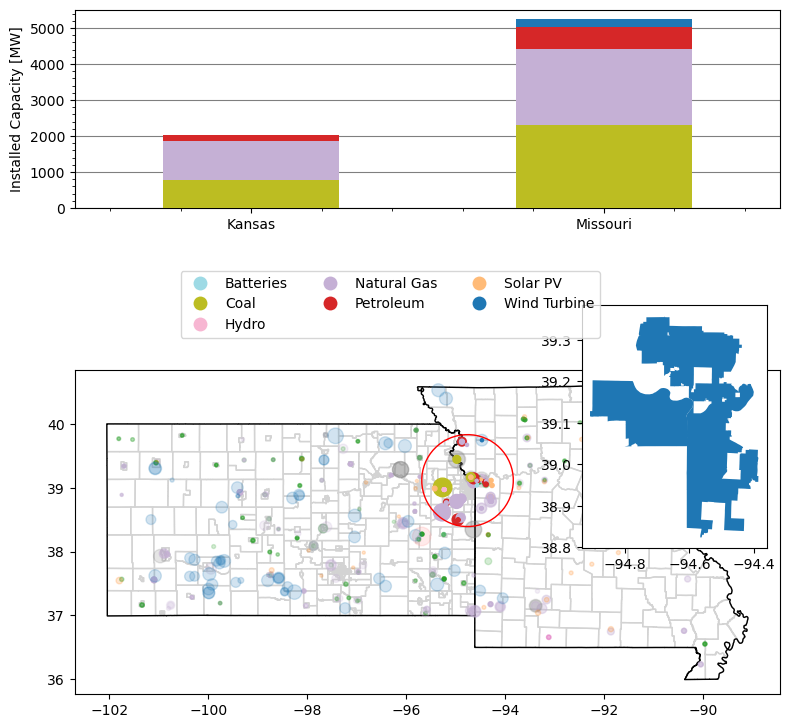

In [385]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8), 
                    #    width_ratios=[1,1],
                       height_ratios=[1,2.5]
                       )
color_map = 'tab20_r'
inset = ax[1].inset_axes([0.65,0.45, 0.4, 0.75])
ks.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
mo.plot(ax=ax[1], facecolor='None',edgecolor='lightgray')
ks.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
mo.dissolve('STATEFP10').plot(ax=ax[1], facecolor='None',edgecolor='k')
gdf.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           alpha=0.2,
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )

buffered_plants.to_crs(epsg=4269).plot(ax=ax[1],
                           column='technology',
                           categorical=True,
                           cmap=color_map,
                           legend=True,
                           legend_kwds=dict(loc=(0.15, 1.1), ncols=3),
                           s=gdf['nameplate-capacity-mw'].astype('float').apply(lambda x: x**(1/2))*5
                        )
# get a buffer zone around Wyandotte County, KS
wyandotte.to_crs(epsg=6922).centroid.buffer(50*1600).to_crs(epsg=4269).plot(ax=ax[1], facecolor='None', edgecolor='r')


buffered_plants_pivot.plot(ax=ax[0], kind='bar', 
                 stacked=True, 
                 cmap=color_map,
                 legend=False,
                 zorder=3)
# ax[0].legend(title='')
ax[0].set_xlabel('')
ax[0].tick_params(axis='x',rotation=0)
ax[0].set_ylabel("Installed Capacity [MW]")
# ax[1].set_axis_off()
ax[0].minorticks_on()
ax[0].yaxis.grid(which='major',linestyle='-', alpha=0.5, color='k',zorder=0)
# ax[0].grid(which='minor',linestyle='--', alpha=0.5)

kc_ksmo.to_crs(epsg=4269).plot(ax=inset)
# inset.set_axis_off()

plt.tight_layout()

<Axes: >

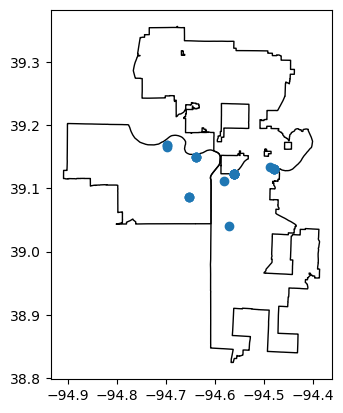

In [376]:
fig, ax = plt.subplots()
kc_ksmo.to_crs(epsg=4326).plot(ax=ax, facecolor='None', edgecolor='k')
gpd.sjoin( gdf, kc_ksmo.to_crs(epsg=4326), how='inner').plot(ax=ax)

<Axes: >

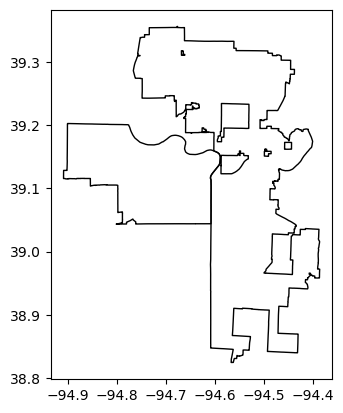

In [368]:
us_cities.xs((slice(None), slice(None), 'Kansas City')).to_crs(epsg=4269).plot(facecolor='None',edgecolor='k')